# Procesamiento Digital de Imágenes Satelitales
# Instituto Gulich - Mayo - Julio 2025

---
#  Clase 08b:  Segmentación de imágenes
---
Lo que veremos en esta notebook:

- [x] Segmentación de imágenes con SLIC - _Simple Linear Iterative Clustering_

```python
import numpy as np
import matplotlib.pyplot as plt

import itertools

import rasterio
from rasterio.plot import show

import geopandas as gpd

from sklearn import mixture

import sys
sys.path.append('../')

from funciones import *

import warnings
warnings.filterwarnings("ignore")
```

```python
path_proc = '../data/proc/'
path_out = '../data/out/'
raster_fn = path_proc + 'S2_dique_20181006.tif'
with rasterio.open(raster_fn) as src:
    img = src.read()
    crs = src.crs
    gt = src.transform
    
# Guardo los datos espectrales, descarto la info espacial.
d, x, y = img.shape
X = img.reshape([d, x*y]).T
```

# Algoritmos de Segmentación
## Segmentemos la imagen usando SLIC
### Simple Linear Iterative Clustering

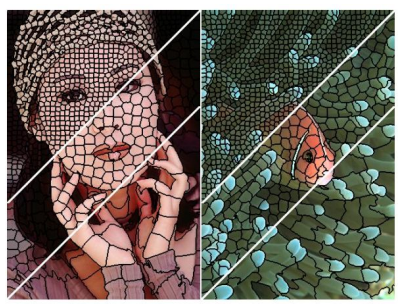

Para usar SLIC, necesitaremos las siguientes librerías:

```python
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
```

Lo primero que necesitamos para el segmentador, es darle una estructura de 3 dimensiones, donde las dimensiones sean (Fila, Columna, Banda). Para ello usamos una función llamada [swapaxes](https://numpy.org/doc/stable/reference/generated/numpy.swapaxes.html) de numpy, que funciona de una manera muy similar al **transpose** de la misma librería que vimos en otras clases. A su vez, vamos a trabajar con la imagenes escaladas aprovechando nuestra función **nequalize**:

```python
print('Dimensión del RGB ecualizado con B, G, NIR: ',
      nequalize(img[[0, 1, 3]]).shape)

print('Dimensión del RGB ecualizado con B, G, NIR luego de aplicar el swap: ',
      np.swapaxes(nequalize(img[[0, 1, 3]]), 0, 1).shape)
```

Como el swap solo lo puedo hacer entre 2 ejes, para llegar a lo que quiero debo volver a aplicarlo:
```python
print('Dimensión del RGB ecualizado con B,G,NIR luego de aplicar el swap sobre el swap: ',
      np.swapaxes(np.swapaxes(nequalize(img[[0, 1, 3]]), 0, 1), 1, 2).shape)
```

Aplicando lo anterior, generamos distintas matrices:

- Una que llamamos `image`, que contiene el Azul, el Verde y el NIR
- Una que llamamos `image_RGB`, que vontiene el Rojo, el Verde y el Azul (Color Natural)
- Una que llamamos `image_full`, que contiene R,G,B,NIR y NDVI

```python
# (X,Y,B) <-> (B,X,Y) donde B es la banda
# B, G, NIR:
image = np.moveaxis(nequalize(img[[0, 1, 3]]), 0, 2)

# R, G, B:
image_RGB = np.moveaxis(nequalize(img[[2, 1, 0]]), 0, 2)

# R, G, B, NIR, NDVI:
image_full = np.moveaxis(nequalize(img[[2, 1, 0, 3, 4]]), 0, 2)

print(f"{image.shape} R, G, NIR")
print(f"{image_RGB.shape} R, G, B")
print(f"{image_full.shape} R, G, B, NIR, NDVI")
```

Ploteamos `image_RGB` con _imshow_ de matplotlib, ya que la estructura que tiene el array RGB sirve para esta función:
```python
plt.imshow(image_RGB)
plt.show()
```

Ahora vamos a hacer la segmentación propiamente dicha. Si miramos la [documentación](https://scikit-image.org/docs/dev/api/skimage.segmentation.html?highlight=slic#skimage.segmentation.slic) de SLIC, veremos que hay muchos parámetros con los cuales se puede jugar. Aquí estableceremos 3 de ellos:

- `image`: Imagen que queremos segmentar.
- `n_segments`: Número de segmentos que queremos obtener.
- `sigma`: Si queremos aplicar algún tipo de suavizado sobre los bordes de los segmentos, utilizamos un valor de sigma. Este puede ser un valor único, o una lista o vector donde especificamos el valor para cada dimensión de la  imagen. El Sigma en este contexo define el ancho de un _kernel_ gaussiano que se usa para suavizar los segmentos.

El siguiente bloque de código va probando la segmentación sobre `image` (la imagen con que tiene B, G y NIR) con 100, 1000 y 10000 segmentos y un valor único de _sigma_ igual a 3. Para plotear los resultados, usa de fondo `image_RGB`. Se utiliza una herramienta de Scikit-Image que se llama [mark_boundaries](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.mark_boundaries), que nos ayuda a superponer los bordes de los segmentos como si fueran vecotres sobre nuestro RGB:

TIP: Prueba ver qué pasa si haces un **imshow()** sobre los segmentos solamente. ¡Vas a ver que mucho no se entiende!
```python
# Iterar por cantidad de segmentos
fig, ax = plt.subplots(3, figsize=(10, 20))
for i, numSegments in enumerate([100, 1000, 10000]):
    # apply SLIC and extract (approximately) the supplied number of segments
    segments = slic(image, n_segments=numSegments, sigma=3)
    # show the output of SLIC    
    ax[i].imshow(mark_boundaries(image_RGB, segments))
    ax[i].axis("off")
    
# show the plots
plt.show()
```

Algo que sucede al trabajar con segmentos, es que reducimos mucho la cantidad total de datos con las que trabajamos:
```python
# La cantidad total de pixels se ve reducida 
print('Número total de píxeles por banda:', 960*1280)
```

Nuestros segmentos siguen siendo un _array_ con la dimensión anterior, pero lo que importa son las etiquetas, porque luego los agruparemos por ese valor. Si consultamos cuantas etiquetas distintas hay, el número es mucho menor a la canidad de píxeles:
```python
# Esta es la estructura de la salida
print(len(np.unique(segments)))

# Asi se ve cada segmento
fig, ax = plt.subplots(figsize=(15, 12))
ax.imshow(segments==50)  # Probar cambiar esta línea para ver otros
plt.show()

```

## Los parámetros de SLIC controlan la forma de los superpixels

### Compactness 

Este parámetro controla el equilibrio entre la proximidad espacial y la similitud en cuanto a su color, de esta manera, si elegimos un valor alto de _compactness_, hará que se de más peso a la proximidad espacial, haciendo los superpíxeles más cuadrados, mientras que un valor bajo, hará que los mismos estén influenciados más por la similitud de su color, por lo que veremos pixeles con formas más irregulares. En la documentación, se recomienda explorar estos valores en una escala logarítmica, por ejemplo: 0.1, 1, 10, 100.

### Sigma
Este parámetro especifica el ancho del kernel del filtro gaussiano que se utilizará en el preprocesamiento de la imagen previo a la segmentación. Usualmente se establece un único valor, el cual se aplica a cada dimensión.

Veamos acá por ejemplo el efecto de un cambio en _sigma_ en una segmentación hecha sobre una zona de nuestra imagen:

```python
imageX = image_RGB[:250, :250, :]

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('sigma = 0 vs sigma = 5')

# primera imagen 
segmentsX = slic(imageX, n_segments=250, sigma=0)
ax[0].imshow(mark_boundaries(nequalize(imageX, p=2), segmentsX))
ax[0].set_title('sigma = 0. No smoothing')

# segunda imagen 
segmentsX = slic(imageX, n_segments=250, sigma=5)
ax[1].imshow(mark_boundaries(nequalize(imageX,p=2), segmentsX))
ax[1].set_title('sigma = 5. Med smoothing')

plt.show()
```

Y en esta celda se ve el efecto de cambios en el parámetro `compactness`. Mientras más alto es el valor, tiene más peso en la definición del segmento la proximidad espacial, que la similaridad en color o tonalidad. Por ello, con valores más altos de este parámetro, los segmentos se parecen cada vez más a una grilla regular.
```python
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Compactness = 3, 10, 25, 50')

values = [3, 10, 25, 50]  # Compactness values
c = 0

for (i, j), ax in np.ndenumerate(axes):
    segmentsX = slic(imageX,
                     n_segments=250,
                     compactness=values[c])
    
    axes[i][j].imshow(mark_boundaries(nequalize(imageX, p=2), segmentsX))
    
    axes[i][j].set_title(f'compactness = {values[c]}')
    
    c += 1

plt.show()
```

## Elijamos una segmentación y avancemos con los clasificadores
```python
numSegments = 128
segments = slic(image, n_segments=numSegments, sigma=5)

fig, ax= plt.subplots(figsize=(15, 10))
ax.imshow(mark_boundaries(image_RGB, segments))
ax.axis("off")
plt.show()
```

Para avazar en la clasificación, vamos a definir un par de funciones que nos ayudarán. En primer lugar, una que nos permite visualizar el valor promedio de cada segmento para cada pixel de un RGB:
```python
def mean_color(image, labels):
    out = np.empty_like(image)
    for label in np.unique(labels):  # Vamos iterando por cada uno de los segmentos o etiquetas
        indices = np.nonzero(labels == label)  # Buscamos las posiciones o índices que corresponden a la etiqueta
        # indices = np.where(labels == label)  # otra opción
        out[indices] = np.mean(image[indices], axis=0)
    return out
```

Las entradas de esa función son una imagen RGB, y una segmentación:
```python
fig = plt.figure(figsize=(12, 10))
plt.imshow(mean_color(image_RGB, segments))
plt.show()
```

La salida de la función es un RGB con el color promediado a nivel de segmento:
```python
mean_color(image_RGB, segments).shape
```

Si cambiamos la imagen de entrada, cambia el color promedio:
```python
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(mean_color(image, segments))
plt.show()
```

# Busquemos una segmentación más fina

```python
numSegments = 2500
segments = slic(image, n_segments=numSegments, sigma=1)

fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(mark_boundaries(image_RGB, segments))
plt.axis("off")
plt.show()

```

```python
# Lo vemos por color promedio:
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(mean_color(image_RGB, segments))
plt.show()
```

## ¿Qué datos le vamos a pasar a un clasificador?

Como queremos pasarle estos datos de color promedio (o incluso prodriamos agregar el desvío estándar) a un clasificador, necesitamos _romper_ la estructura espacial. Sin embargo, como queremos agrupar el dato por segmento, y no por pixel, debemos hacer algunas operaciones intermedias. Para ello nos ayudamos de la función `compute_mean_data` que toma como argumentos:

- La imagen de entrada
- Los segmentos de referencia
- Un parámetro `compute_std` , que por defecto es `False`. Si lo cambiamos a `True`, además de la media se calculará el desvío estándar del color de cada segmento. 

```python
def compute_mean_data(data, labels, compute_std=False):
    data_dim = data.shape[2]  # Número de bandas (3 dimensión)
    if compute_std:
        # Si vamos a agregar el desvío estándar
        data_dim *= 2
    nlabels = labels.max() + 1  # Cantidad de etiquetas + 1
    out = np.zeros([nlabels, data_dim])
    for label in np.unique(labels):
        datal = data[labels==label]  # Filtro los datos correspondientes al segmento
        if compute_std:
            # hstack entre la media y el desvío
            label_summary = np.hstack((datal.mean(axis=0),
                                       datal.std(axis=0))) 
        else:
            label_summary = datal.mean(axis=0)
        
        # Cargo las métricas calculadas: media o media + desvio
        out[label] = label_summary
    return out
```

Como salida, tenemos una especie de _tabla_ donde cada una de nuestras filas representas nuestros segmentos, y cada columna corresponde a la media de cada una de las bandas de la imagen de entrada. Si también agregamos el desvío estándar, tendremos el doble de columnas:

```python
mean_data = compute_mean_data(image_full, segments)
print('Dimensiones, media: ', mean_data.shape)

mean_data_std = compute_mean_data(image_full,
                                  segments,
                                  compute_std=True)
print('Dimensiones, media + desvío estandar: ', mean_data_std.shape)
```

# Hagamos una clasificación GMM en 12 clusters

En este caso, nuestra entrada será `mean_data`:
```python
gmm = mixture.GaussianMixture(n_components=12,
                              covariance_type='full')

#fit_predict es lo mismo que hacer gmm.fit(mean_data) primero, y luego gmm.predict(mean_data)
segment_labels = gmm.fit_predict(mean_data)

print('Valores únicos de etiquetas: ', np.unique(segment_labels))
```

Con esta celda, le pasamos nuestras etiquetas clasificadas a nuestro _array_ de segmentos originales:
```python
l = map(lambda s: segment_labels[s], segments.flatten())
final_labels = np.array(list(l)).reshape(segments.shape)

# Ploteamos
mc_img = mean_color(image_RGB, final_labels)

fig, ax = plt.subplots(1, 2, figsize=(25, 10))
# imageX = image_RGB[:250, :250, :]

#primer imagen 
ax[0].imshow(mc_img)
ax[0].set_title('Clasificación')

#segunda imagen 
ax[1].imshow(image_RGB)
ax[1].set_title('RGB')

plt.show()
```

# Comparo el clustering así obtenido (12 clusters) con los ROIs originales

```python
# Datos de la capa vectorial
path_shp = '../data/raw_data/vector/'
rois_shp = gpd.read_file(os.path.join(path_shp, 'rois_dique3.geojson'))
```

```python
fig, ax = plt.subplots(figsize=(12, 12))
# rois_shp.plot(ax=ax, column='clase')
rois_shp.boundary.plot(ax=ax, color='orangered')
show(np.moveaxis(mc_img, 2, 0), transform=gt, ax=ax)
plt.show()
```

## Podríamos considerar los desvíos de cada segmento

Como vimos antes, si corremos la función `compute_mean_data` con el parámetro `compute_std=True`, tendremos una entrada para clasificar más grande:
```python
mean_data_std = compute_mean_data(image_full,
                                  segments,
                                  compute_std=True)
print(mean_data_std.shape)
```

Tomemos por ejemplo el NDVI medio (ocupa la posición 4), y su desvío estándar (ocupa la posición 9):
```python
fig, ax = plt.subplots()
ax.scatter(mean_data_std[:, 4], mean_data_std[:, 9])
ax.set_xlabel('NDVI promedio')
ax.set_ylabel('NDVI std')
plt.show()
```

Podemos probar cómo da el GMM considerando solo el promedio del NDVI, o el NDVI más su promedio:

```python
# Solo NDVI
gmm = mixture.GaussianMixture(n_components=15,
                              covariance_type='full')

# Tomo el promedio del NDVI
segment_labels_mndvi = gmm.fit_predict(mean_data_std[:, [4]])

# Pongo las nuevas etiquetas a los pixeles
l = map(lambda s : segment_labels_mndvi[s], segments.flatten())
pixel_labels_mndvi = np.array(list(l)).reshape(segments.shape)
```

```python
gmm = mixture.GaussianMixture(n_components=15,
                              covariance_type='full')

# Tomo el promedio del NDVI + su desvío
segment_labels_msndvi = gmm.fit_predict(mean_data_std[:, [4, 9]])

# Pongo las nuevas etiquetas a los pixels
l = map(lambda s: segment_labels_msndvi[s], segments.flatten())
pixel_labels_msndvi = np.array(list(l)).reshape(segments.shape)
```

```python
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

# primera imagen 
ax[0].scatter(mean_data_std[:, 4],
              mean_data_std[:, 9],
              c=segment_labels_mndvi)

ax[0].set_title('mean ndvi')

# segunda imagen 
ax[1].scatter(mean_data_std[:, 4],
              mean_data_std[:, 9],
              c=segment_labels_msndvi)

ax[1].set_title('mean + std ndvi')

plt.show()
```

Tomar solo el promedio del NDVI, genera fronteras de división más lineales entre las clases. Tomar el desvío toma en cuenta la variabilidad interna dentro de cada segmento. Veamoslo como imagen:

```python
# ploteo
mndvi_img  = mean_color(image_RGB, pixel_labels_mndvi)
msndvi_img = mean_color(image_RGB, pixel_labels_msndvi)

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# primera imagen 
ax[0][0].imshow(mndvi_img)
ax[0][0].set_title('Clasificación con mean ndvi')

# segunda imagen 
ax[0][1].imshow(msndvi_img)
ax[0][1].set_title('Clasificación con mean+std ndvi')

# Imagen original RGB
ax[1][0].imshow(image_RGB)
ax[1][0].set_title('RGB original')

# Etiquetas
ax[1][1].imshow(pixel_labels_msndvi)
ax[1][1].set_title('Etiquetas - mean+std ndvi')
plt.show()
```

# Selección de modelos
### Ahora que tenemos la segmentación, redujimos la cantidad de datos. Tratemos de buscar la cantidad óptima de clases en este nuevo contexto

```python
# Recordemos que usamos la función compute_mean_data 
# Usamos todos los atributos, calculando la media de cada segmento:
mean_data = compute_mean_data(image_full, segments)
```

Aquí repetimos lo que hicimos en la notebook anterior con un GMM, pero ahora buscamos sobre `mean_data`, no sobre todos los píxeles. Entonces podemos probar sobre un espacio o grilla de hiper-parámetros mucho más grande:

```python
print('Valores de n_components sobre los que se hará la búsqueda: ',
      np.arange(5, 91, 5))
```

```python
lowest_bic = np.inf
bic = []

# Tengo un dataset mucho mas pequeño ahora. Voy a hacer pruebas variando n_componets de 5 a 100, yendo
# de 5 en 5. Probar en una celda separada que devuelve np.arange(5, 101, 5):
n_components_range = np.arange(5, 91, 5)

#Vamos a probar sobre todas las formas de covarianza
cv_types = ["spherical", "tied", "diag", "full"]

print('BIC for different models')
for cv_type in cv_types:
    for n_components in n_components_range:
        # ajustá un Gaussian mixture 
        print(cv_type, n_components, end=': ')
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(mean_data)
        gmmbic = gmm.bic(mean_data)
        print(gmmbic)
        bic.append(gmmbic)
        # se queda con el mejor bic y recuerda el mejor modelo también
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
clf = best_gmm
```

Usamos la siguiente celda para plotear los resultados:

```python
color_iter = itertools.cycle(['navy',
                              'turquoise',
                              'cornflowerblue',
                              'darkorange'])
bars = []
# Plot the BIC scores
plt.figure(figsize=(15, 10))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos,
                        bic[i*len(n_components_range):
                            (i + 1)*len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
#plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model - Only mean values')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
#plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
plt.show()
```

Los mejores resultados de BIC parecen situarse en torno a los 15-20 componentes y, al igual que la Notebook anterior, la forma de la covarianza que mejor resultado arroja es _full_ o completa. Focalicemos un poco más la busqueda (las pruebas) corriendo el GMM con esta covarianza y yendo de 5 a 25 componentes con mayor granularidad (observa como definimos el `n_components_range` más abajo:

```python
lowest_bic = np.inf
bic = []
n_components_range = np.arange(5,25)
cv_types = ['full']

print('BIC for different models')
for cv_type in cv_types:
    for n_components in n_components_range:
        # ajustá un Gaussian mixture 
        print(cv_type, n_components, end=': ')
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(mean_data)
        gmmbic = gmm.bic(mean_data)
        print(gmmbic)
        bic.append(gmmbic)
        # se queda con el mejor bic y recuerda el mejor modelo también
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
clf = best_gmm
```

Ploteamos los resultados:

```python
color_iter = itertools.cycle(['navy',
                              'turquoise',
                              'cornflowerblue',
                              'darkorange'])
bars = []
# Plot the BIC scores
plt.figure(figsize=(15, 10))
spl = plt.subplot(2, 1, 1)
xpos = np.array(n_components_range) 
bars.append(plt.bar(xpos, bic, width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per ncomponents - Full GMM model - datos sin desvios')
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
```

Buscamos el valor de `n_components` para el cual obtuvimos el mejor BIC:
```python
best_n_components = n_components_range[np.argmin(bic)]
print(f'El mejor BIC se alcanzó para {best_n_components} componentes')
```

Con este valor encontrado, entrenamos el clasificador sobre nuestros segmentos, y luego le pasamos las estiquetas de esos segmentos a todos nuestros píxeles:

```python
gmm = mixture.GaussianMixture(n_components=best_n_components,
                              covariance_type='full')
segment_labels = gmm.fit_predict(mean_data)


# pongo las nuevas etiquetas a los pixels
l = map(lambda s : segment_labels[s], segments.flatten())
final_labels = np.array(list(l)).reshape(segments.shape)
```

```python
# ploteo
mc_img = mean_color(image_RGB, final_labels)

fig, ax = plt.subplots(1, 2, figsize=(25, 10))

# primera imagen 
ax[0].imshow(mc_img)
ax[0].set_title('clasificación')

# segunda imagen 
ax[1].imshow(image_RGB)
ax[1].set_title('RGB')

plt.show()
```

Guardamos el resultado (`final_labels`) como Geotiff:
```python
guardar_GTiff(path_out+'Dique_Clust_GMM_segm_mean_Winner.tif',
              crs,
              gt,
              final_labels)
```

### Ejercicio 12.1
1. Usando SLIC, rehacer una segmentación de la imágen de trabajo basada en las bandas B, G y NIR, en la que cada superpixel tenga, en promedio, una hectárea.
2. Para la segmentación obtenida hacer un clustering basado en las medias en cada segmento de los 5 atributos (R,G,B,NIR, NDVI), usando el algoritmo GMM, de manera de obtener 10 clases de espectrales diferentes.
3. Repetí incorporando los desvíos. Antes de correr el GMM reescalá los datos con StandarScaler(from sklearn.preprocessing import StandardScaler). ¿Qué diferencias observás?
4. Exportar el resultado en un GeoTIFF.
5. Usar el criterio BIC para seleccionar la cantidad de componentes adecuada para un modelo GMM y decidir si es conveniente usar una matriz de covarianza diagonal ('diag') o completa ('full')
6. Para la cantidad de componentes y el tipo de matriz seleccionado, correr 10 ajustes del GMM (fit) y quedarse con el que ajuste mejor (menor BIC).
7. Exportar el resultado en un GeoTIFF.
